In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
ratings: pd.DataFrame = pd.read_parquet("../data_raw/ratings.pq")
movies: pd.DataFrame = pd.read_parquet("../data/movies_data.pq")
merged: pd.DataFrame = ratings.merge(movies, left_on="movieId", right_on="movielens_id")

## Filter movies

<Axes: >

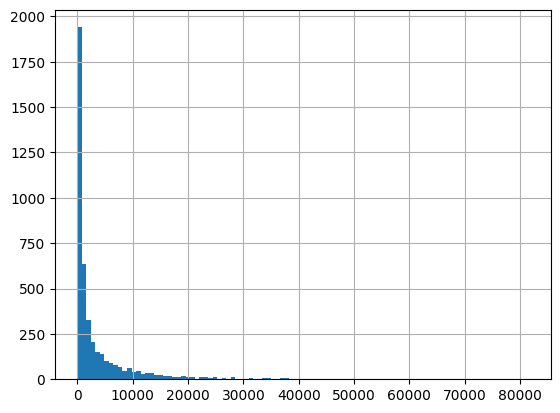

In [3]:
# distribution of number of ratings given to each movie
merged.movieId.value_counts().hist(bins=100)

(12635445, 18)


<Axes: >

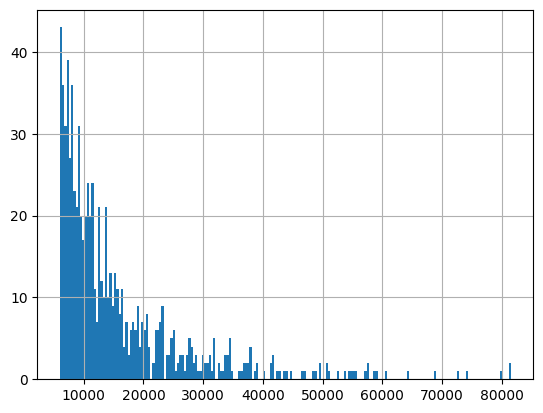

In [5]:
# remove movies with too few ratings (no upper threshold, as it is normal for movies to have a lot of ratings)
UPPER_THRESHOLD = merged.shape[0]
LOWER_THRESHOLD = 6000

movies_occurences = merged.movieId.value_counts()
tmp: pd.DataFrame = merged[
    merged.movieId.isin(
        movies_occurences[(movies_occurences < UPPER_THRESHOLD) & (movies_occurences > LOWER_THRESHOLD)].index
    )
]
print(tmp.shape)
tmp.movieId.value_counts().hist(bins=200)

In [ ]:
merged = tmp
ratings = ratings[ratings.movieId.isin(merged.movieId)]

## Filter users

<Axes: >

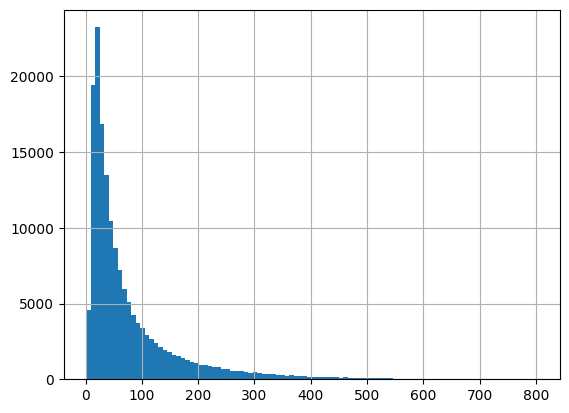

In [7]:
# distribution of number of ratings given by each user
ratings.userId.value_counts().hist(bins=100)

(11996179, 4)


<Axes: >

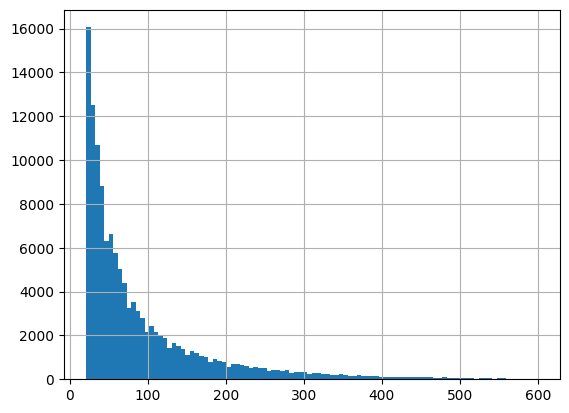

In [9]:
# it seems strange for people to give ratings for too many movies; too few ratings seem not very useful
UPPER_THRESHOLD = 600  # pylint: disable=invalid-name
LOWER_THRESHOLD = 20  # pylint: disable=invalid-name

users_occurences: pd.Series = ratings.userId.value_counts()
tmp = ratings[
    ratings.userId.isin(
        users_occurences[(users_occurences < UPPER_THRESHOLD) & (users_occurences > LOWER_THRESHOLD)].index
    )
]
print(tmp.shape)
tmp.userId.value_counts().hist(bins=100)

In [ ]:
ratings = tmp

## Train-Test split

In [11]:
# for test we save TEST_RATIO share of last ratings given by each user
TEST_RATIO = 0.2

test_data = pd.DataFrame(columns=ratings.columns)
train_data = pd.DataFrame(columns=ratings.columns)

users: np.array = ratings.userId.unique()
for u in tqdm(users):
    tmp = ratings[ratings.userId == u]
    n = len(tmp)
    test_size = int(TEST_RATIO * n)
    tmp = tmp.sort_values("timestamp").reset_index(drop=True)

    train_slice: pd.DataFrame = tmp.iloc[: n - test_size, :]
    test_slice: pd.DataFrame = tmp.iloc[n - test_size :, :]

    test_data = pd.concat([test_data, test_slice])
    train_data = pd.concat([train_data, train_slice])

100%|██████████| 128665/128665 [6:51:02<00:00,  5.22it/s]  


In [12]:
# check that all users presented in test are also presented in train and vice versa
print(set(test_data.userId) - set(train_data.userId))
print(set(train_data.userId) - set(test_data.userId))

set()
set()


In [13]:
# check that all movies presented in test are also presented in train and vice versa
print(set(test_data.movieId) - set(train_data.movieId))
print(set(train_data.movieId) - set(test_data.movieId))

set()
set()


## Reindex datasets

In [16]:
userid_mapping = {u: i for i, u in enumerate(np.sort(train_data.userId.unique()))}
train_data["userId"] = train_data.userId.apply(lambda x: userid_mapping[x])
test_data["userId"] = test_data.userId.apply(lambda x: userid_mapping[x])

In [17]:
movieid_mapping = {m: i for i, m in enumerate(np.sort(train_data.movieId.unique()))}
train_data["movieId"] = train_data.movieId.apply(lambda x: movieid_mapping[x])
test_data["movieId"] = test_data.movieId.apply(lambda x: movieid_mapping[x])

In [18]:
movies_data: pd.DataFrame = pd.read_parquet("data/movies_data.pq").rename(
    columns={"movielens_id": "movieId", "movie_plot": "plot"}
)
movies_data = movies_data[movies_data.movieId.isin(movieid_mapping.keys())]
movies_data["movieId"] = movies_data.movieId.apply(lambda x: movieid_mapping[x])

In [20]:
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
movies_data = movies_data.reset_index(drop=True)

## Save datasets

In [23]:
train_data.to_parquet("../data/ratings_train.pq")
test_data.to_parquet("../data/ratings_test.pq")
movies_data.to_parquet("../data/movies_train.pq")